In [2]:
import ast
import pandas as pd

import src.embeddings as emb
import src.similarity as sim
import src.clustering as clu
import src.metrics as met
import src.metrics_fr as fr
import src.utils as utils

from collections import Counter

/Users/erikluu/Documents/Poly/Thesis/LociNet/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Thesis Evaluation

## Helper Functions

In [4]:
def load_data(filepath, n=None):
    assert filepath[-4:] == ".csv", "Must be a .csv file"
    data = pd.read_csv(filepath)
    if n:
        data = data.head(n)

    attrs = {
        "titles": data["title"].tolist(),
        "text": data["text"].tolist(),
        "tags": data["tags"].apply(ast.literal_eval).tolist(),
        "ids": data.index.tolist()
    }

    if "simplified_tags" in data.columns:
        attrs["simplified_tags"] = data["simplified_tags"].apply(ast.literal_eval).tolist()

    return attrs

def load_embeddings(dataset_name, model_names):
    embeddings = []
    for name in model_names:
        embeddings.append(utils.load_from_pickle(f"embeddings/{dataset_name}_{name}_n10000.pickle"))
    return embeddings

## Metric Helper Functions

In [11]:
def get_embedding_similarity_metrics_per_data(dataset_name, dataset_tags, model_names):
    dataframes = []

    for model_name in model_names:
        embeddings = utils.load_from_pickle(f"embeddings/{dataset_name}_{model_name}_n10000.pickle")
        cosine_sim, soft_cosine_sim, euclidean_sim = sim.get_all_similarities(embeddings)
        dataframes.append(fr.calculate_embedding_metrics_for_all(cosine_sim, soft_cosine_sim, euclidean_sim,
                                        dataset_tags, model_name, dataset_name))
    
    return pd.concat(dataframes)

## Data: interview_prep.csv

In [6]:
data_name = "interview_prep"
data = load_data(f"data/{data_name}.csv")

### Embedding and Similarity Scores

In [12]:
df = get_embedding_similarity_metrics_per_data("interview_prep", data["tags"],
                                             ["minilm", "mpnet", "nomic", "bert", "specter", "word2vec"])

Calculating euclidean similarities: 100%|██████████| 1/1 [00:00<00:00, 2187.95it/s]


In [4]:
model_name = "minilm"
embeddings = emb.process_embeddings(data["text"], model_name)
cosine_sim, soft_cosine_sim, euclidean_sim = sim.get_all_similarities(embeddings)
all_mini_df = met.calculate_embedding_metrics_for_all(cosine_sim, soft_cosine_sim, euclidean_sim,
                                        data["tags"], model_name, data_name)

Initializing sentence-transformers/all-MiniLM-L6-v2 Model


Calculating euclidean similarities: 100%|██████████| 1/1 [00:00<00:00, 321.97it/s]


In [5]:
model_name = "nomic"
embeddings = emb.process_embeddings(data["text"], model_name)
cosine_sim, soft_cosine_sim, euclidean_sim = sim.get_all_similarities(embeddings)
nomic_df = met.calculate_embedding_metrics_for_all(cosine_sim, soft_cosine_sim, euclidean_sim,
                                        data["tags"], model_name, data_name)

Initializing Nomic Model


<All keys matched successfully>
Calculating euclidean similarities: 100%|██████████| 1/1 [00:00<00:00, 1323.96it/s]


In [6]:
model_name = "bert"
embeddings = emb.process_embeddings(data["text"], model_name)
cosine_sim, soft_cosine_sim, euclidean_sim = sim.get_all_similarities(embeddings)
bert_df = met.calculate_embedding_metrics_for_all(cosine_sim, soft_cosine_sim, euclidean_sim,
                                        data["tags"], model_name, data_name)

Initializing Google BERT Model


Calculating euclidean similarities: 100%|██████████| 1/1 [00:00<00:00, 1420.83it/s]


In [7]:
combined_df = pd.concat([all_mini_df, nomic_df], ignore_index=True)
melted_df = combined_df.melt(id_vars=['data_source', 'embedding_model', 'metric_name', 'metric'], 
                             value_vars=['between_all_nodes', 'between_shared_tags'], 
                             var_name='comparison_type', value_name='value')

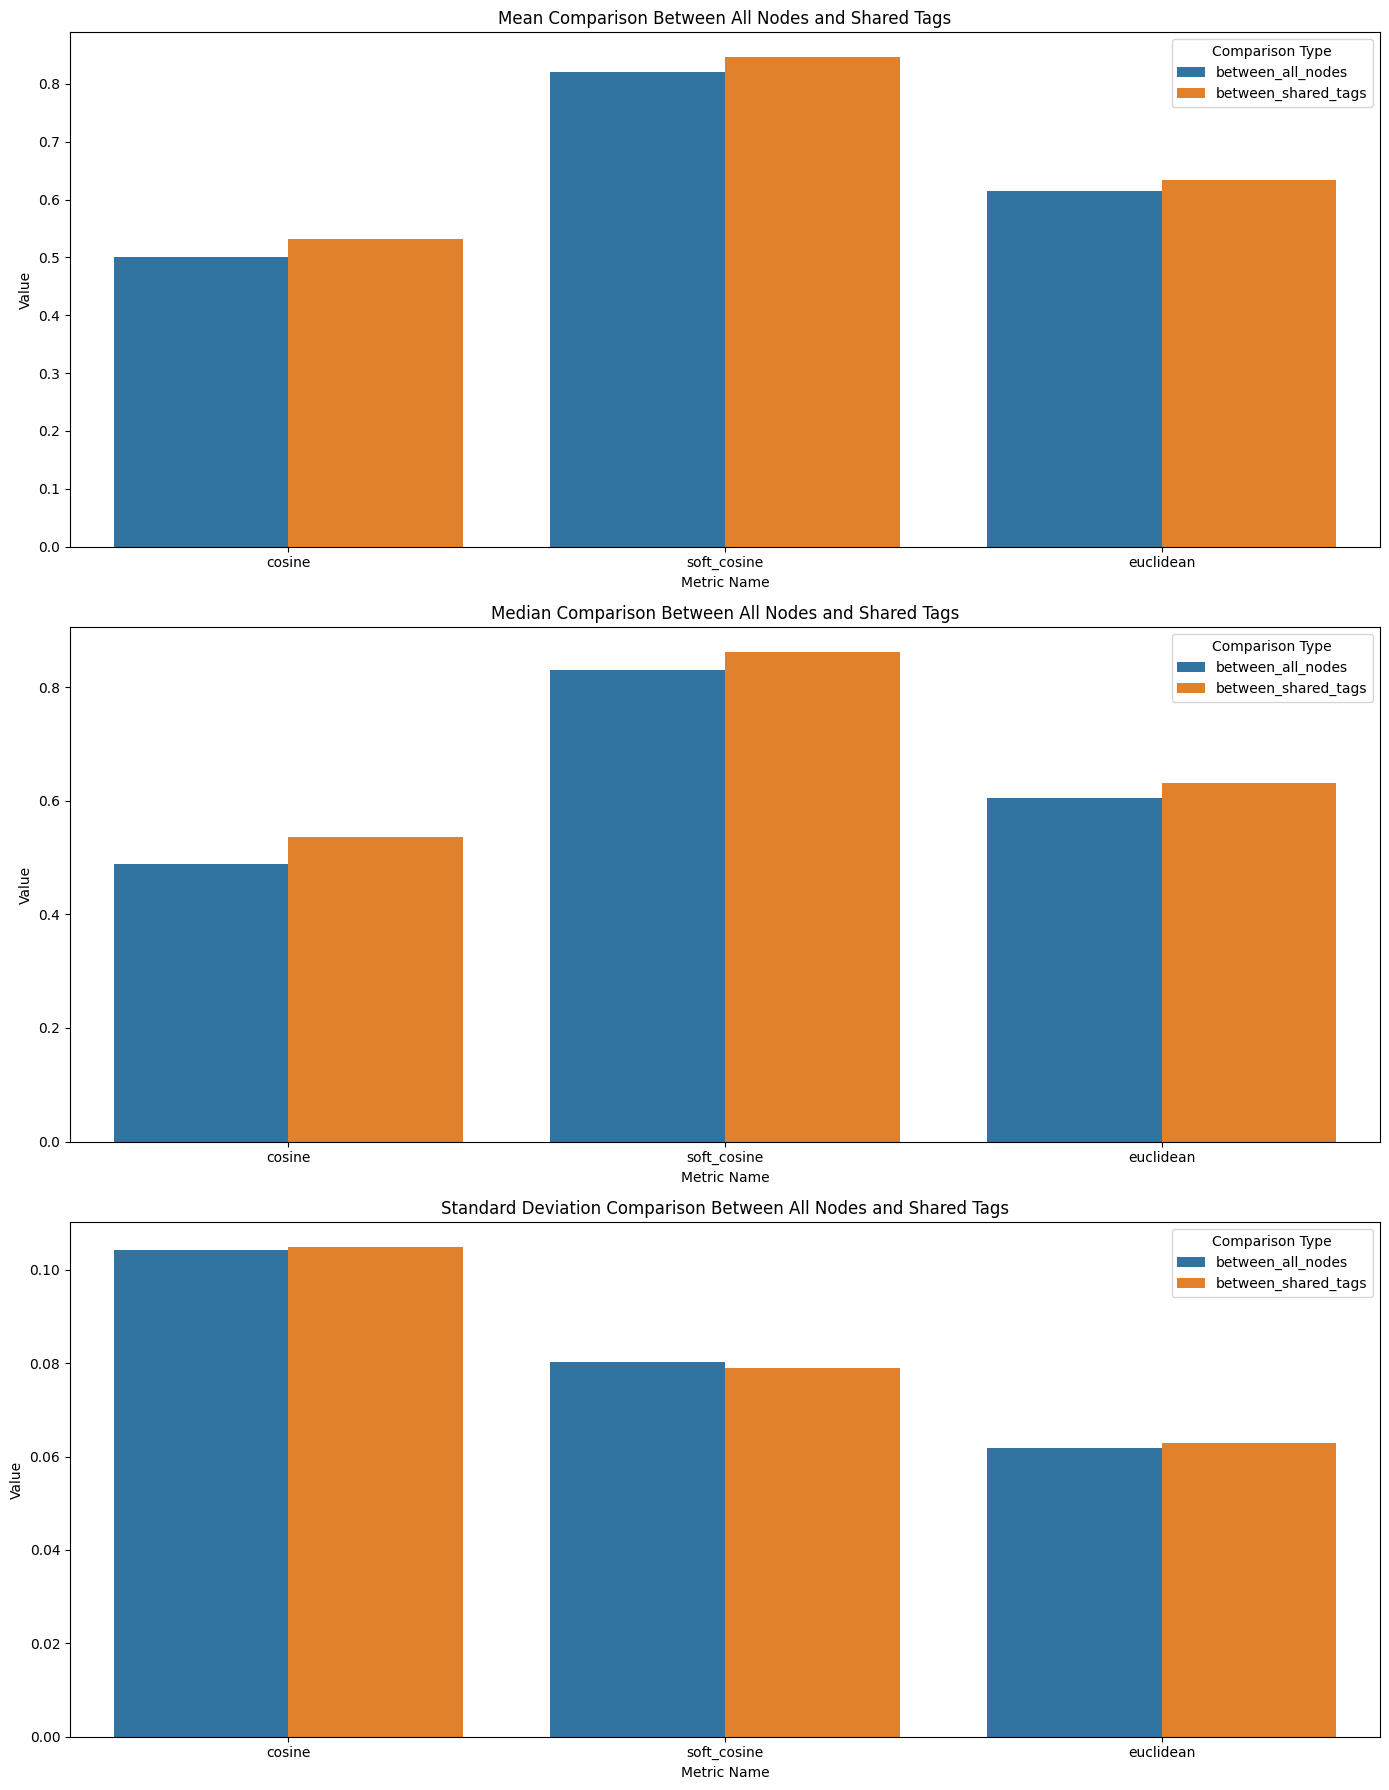

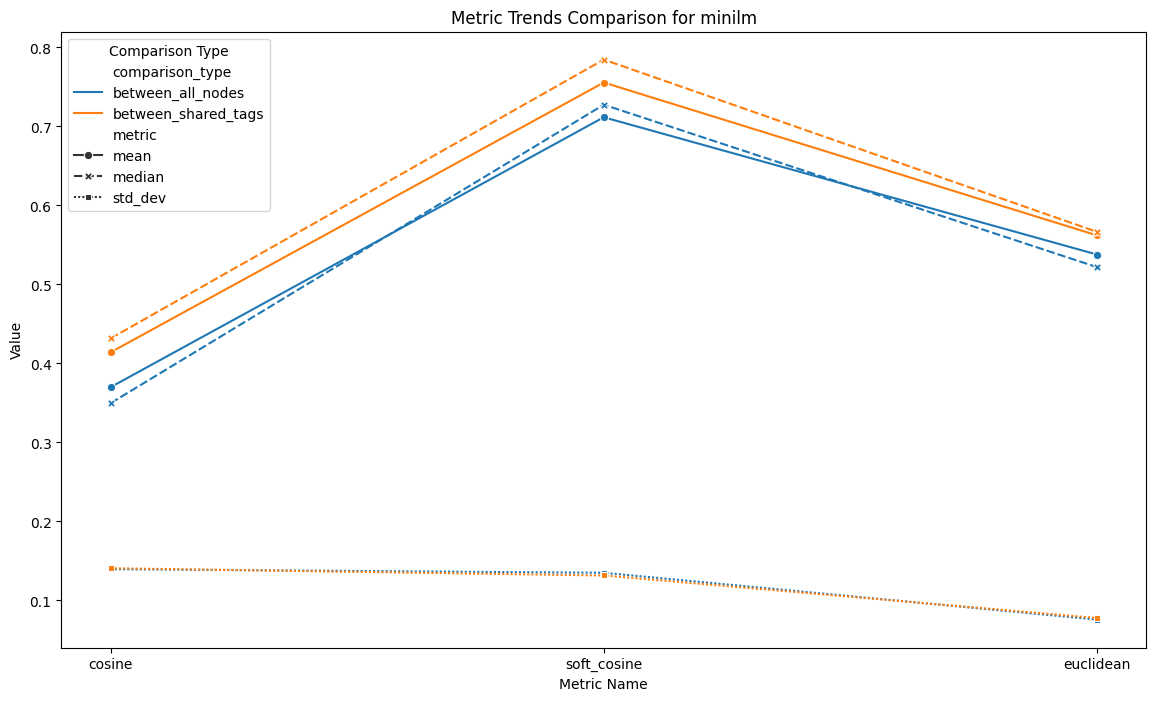

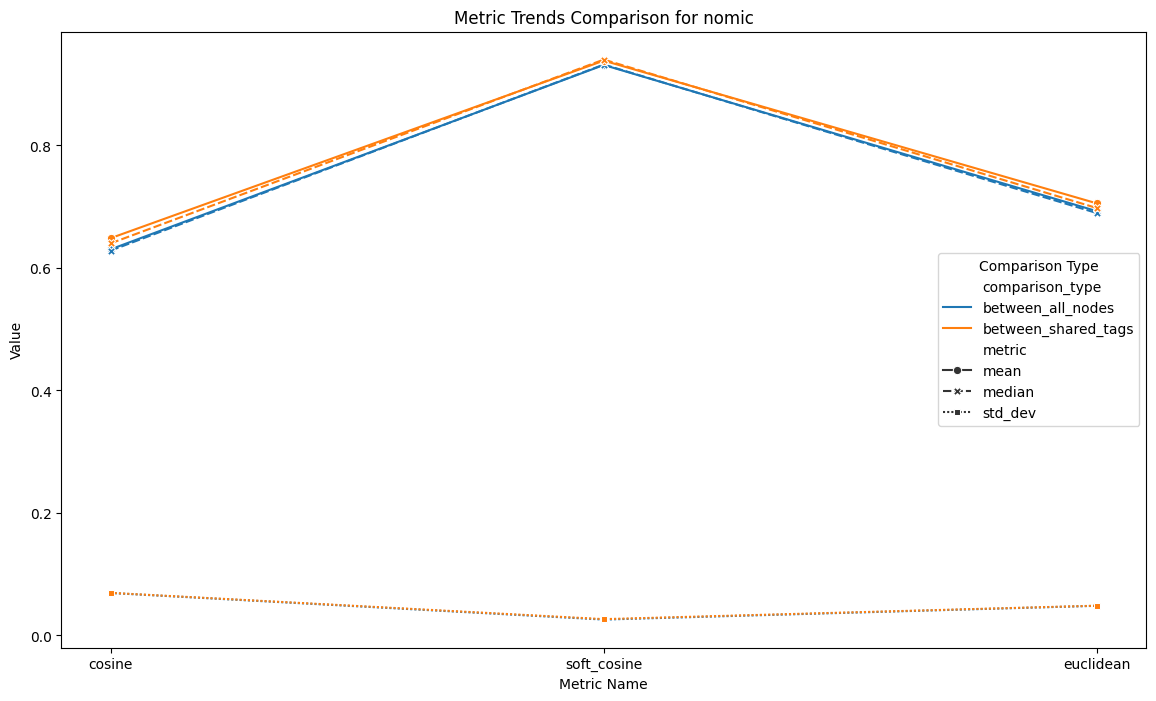

In [8]:
met.visualize_embeddings_comparisons([all_mini_df, nomic_df])

### Cluster Purity
- Custom thing
- Homogeneity
- Completeness

In [25]:
def evaluate_models_and_clusterers(data, embedding_models, embeddings, clusterers, k=2):
    results = []
    for name, e in zip(embedding_models, embeddings):
        for clusterer_name, clusterer_f in clusterers.items():
            clusters = clusterer_f(e)
            cluster_tags = {i: [] for i in range(max(clusters) + 1)}

            for i, cluster_id in enumerate(clusters):
                cluster_tags[cluster_id].extend(data['tags'][i])  # Assuming data is a list of dictionaries with 'tags' field

            total_tag_counts = Counter(tag for tags in cluster_tags.values() for tag in tags)
            metrics_df = met.calculate_metrics_dataframe(cluster_tags, total_tag_counts, k)
            metrics_df["Model"] = name
            metrics_df["Clusterer"] = clusterer_name

            results.append(metrics_df)

    final_df = pd.concat(results, ignore_index=True)
    return final_df

In [26]:
embedding_models = ["nomic", "minilm", "mpnet", "bert", "specter"]
embeddings = load_embeddings("medium1k", embedding_models)
clusterers = {
    "kmeans": lambda x: clu.kmeans(x, n_clusters=5),
    "dbscan": lambda x: clu.dbscan(x)
}
evaluate_models_and_clusterers(data, embedding_models, embeddings, clusterers)

IndexError: list index out of range

In [9]:
model_name = "minilm"
embeddings = emb.process_embeddings(data["text"], model_name)
clusterer_f = lambda x: clu.kmeans(x, n_clusters=5)
clusters = met.get_clusters_with_tags(embeddings, data["tags"], clusterer_f)
tag_counts = met.get_tags_count(data["tags"])
met.calculate_metrics_dataframe(clusters, tag_counts, k=2)

Initializing sentence-transformers/all-MiniLM-L6-v2 Model


Processing batch: This is a project I ...: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


,Tag,Purity,Homogeneity,Completeness
0,haha,0.555556,0.285179,0.132731
1,hehe,0.400000,0.285179,0.132731


## Data: Medium (n=1000)

In [8]:
df = get_embedding_similarity_metrics_per_data("medium1k", data["tags"],
                                             ["minilm"])
#  "mpnet", "nomic", "bert", "specter"]

In [ ]:
# all_minilm_df = met.calculate_embedding_metrics_for_all(minilm_cosine_sim, minilm_soft_cosine_sim, minilm_euclidean_sim,
#                                         tags, "minilm", data_name)
# all_mpnet_df = met.calculate_embedding_metrics_for_all(mpnet_cosine_sim, mpnet_soft_cosine_sim, mpnet_euclidean_sim,
#                                         tags, "mpnet", data_name)
# nomic_df = met.calculate_embedding_metrics_for_all(nomic_cosine_sim, nomic_soft_cosine_sim, nomic_euclidean_sim,
#                                         tags, "nomic", data_name)
# bert_df = met.calculate_embedding_metrics_for_all(bert_cosine_sim, bert_soft_cosine_sim, bert_euclidean_sim,
#                                         tags, "bert", data_name)
# specter_df = met.calculate_embedding_metrics_for_all(specter_cosine_sim, specter_soft_cosine_sim, specter_euclidean_sim,
#                                         tags, "specter", data_name)

In [ ]:
# combined_df = pd.concat([all_minilm_df, nomic_df, all_mpnet_df, bert_df, specter_df], ignore_index=True)
# melted_df = combined_df.melt(id_vars=['data_source', 'embedding_model', 'metric_name', 'metric'], 
#                              value_vars=['between_all_nodes', 'between_shared_tags'], 
#                              var_name='comparison_type', value_name='value')